In [1]:
import numpy as np
import os, sys, glob
import matplotlib.pyplot as plt
import open3d as o3d
from scipy.stats import chisquare
import pandas as pd

basedir = os.path.dirname(os.getcwd())
_py = os.path.join(basedir, 'py')
_data = os.path.join(basedir, 'data')
_images = os.path.join(basedir, 'images')

sys.path.insert(1, _py)
import lad
import figures

from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

%matplotlib qt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2021-09-22 22:12:56,436 - utils - NumExpr defaulting to 4 threads.


## Ray tracing

Requisites:
* Raw files (blensor ouputs) shoul be placed in the root of the directory
* Raw files should be named `s1*.npy`, `s2*.npy`, etc
* Create a file with sensor positions in the root with name `scanner_pos.txt`. It should contain 4 columns:
    * sensor name i.e. `s1`, `s2`, etc
    * x coordinate
    * y coordinate
    * z coordinate

In [40]:
#
mockname = 'single_tmp'
res = 0.005
debug = True
downsample_debug = 15
# scan_inc = 90

tracers = lad.get_all_traces(mockname, res=res, debug=debug, downsample_debug=downsample_debug)
# get_lad(mockname, res, debug=debug, downsample_debug=downsample_debug)

/home/omar/myproj/planttech/data/single_tmp/s100000.npy
s100000.npy 	 beam traces points in tree tree_0: 	 6000 --> 10860163
/home/omar/myproj/planttech/data/single_tmp/s300000.npy
s300000.npy 	 beam traces points in tree tree_0: 	 6000 --> 11200583
/home/omar/myproj/planttech/data/single_tmp/s200000.npy
s200000.npy 	 beam traces points in tree tree_0: 	 6000 --> 11260150
/home/omar/myproj/planttech/data/single_tmp/s400000.npy
s400000.npy 	 beam traces points in tree tree_0: 	 6000 --> 11201793


In [5]:
figures.show_beams(mockname, sample=100, tracers=True, res=3)

In [52]:
#
mockname = 'single_tmp'
res = 0.005 # only to look in the correct file
debug = True
downsample_debug = 15
voxel_size = 0.07
# scan_inc = 130
# alpha = 0.2
# kbins = 2

m3att, meshfile, bia, voxk, lia, ws, resdir = lad.get_lad(mockname, res=res, debug=debug, downsample_debug=downsample_debug, voxel_size=voxel_size)

/home/omar/myproj/planttech/data/single_tmp/mesh.ply
Stage 1: 2.65260075599997
9.38 9.590000000000002 5.8100000000000005
Stage 2: 13.156701665000014
max --> [133, 136, 82]
min --> [0, 0, 0]
(134, 137, 83)
Stage 3: 5.126502298999981
Number of voxels ocupied by points cloud: 	 8161
Number of voxels ocupied by beam points cloud: 	 661255
Total number of voxels in plant regions: 	 1523714
Number of voxels with attribute 1: 	 8161
Number of voxels with attribute 2: 	 658318
Number of voxels with attribute 3: 	 857235
Stage 4: 8.326152875999924
Stage 5: 0.3425393149999536


In [57]:
alphas_k = lad.alpha_k(bia, voxk, lia, ws, resdir)

In [58]:

kbins = 4
lads_min = lad.get_LADS(m3att, voxel_size, kbins, alphas_k[:,2], 1)
lads_max = lad.get_LADS(m3att, voxel_size, kbins, alphas_k[:,4], 1)
lads_mid = lad.get_LADS(m3att, voxel_size, kbins, alphas_k[:,6], 1)
lads_0 = lad.get_LADS(m3att, voxel_size, kbins, alphas_k[:,6]*0+1, 1)
kmax = m3att.shape[2]
lads_mesh = lad.get_LADS_mesh(meshfile, voxel_size, kbins, kmax)

In [59]:
fig = plt.figure(figsize=(4, 6))
plt.plot(lads_min[0:,1], lads_min[0:,0], marker='*', label='Estimated min')
plt.plot(lads_max[0:,1], lads_max[0:,0], marker='*', label='Estimated max')
plt.plot(lads_mesh[0:,1], lads_mesh[0:,0], marker='s', c='k', label='Truth')
plt.plot(lads_mid[0:,1], lads_mid[0:,0], marker='*', label='Estimated mid')
plt.plot(lads_0[0:,1], lads_mid[0:,0], marker='*', label='Estimated 0')

plt.xlabel(r'LAD ($m^2/m^3$)')
plt.ylabel(r'Height ($m$)')
# plt.grid()
plt.legend()
# plt.show()
# plt.xlim(-2,2)

mockdir = os.path.join(_data, mockname)
resdir_name = '%s_%s' %('results', mockname)
resdir = os.path.join(mockdir, resdir_name)
savefig = os.path.join(resdir, 'LADs.png')
plt.savefig(savefig, dpi=200, bbox_inches='tight')

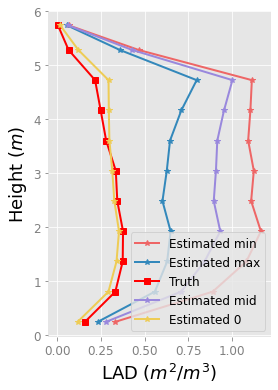

In [6]:
plt.figure(figsize=(4, 6))
plt.plot(lads_min[0:,1], lads_min[0:,0], marker='*', label='Estimated min')
plt.plot(lads_max[0:,1], lads_max[0:,0], marker='*', label='Estimated max')
plt.plot(lads_mesh[0:,1], lads_mesh[0:,0], marker='s', c='r', label='Truth')
plt.plot(lads_mid[0:,1], lads_mid[0:,0], marker='*', label='Estimated mid')
plt.plot(lads_0[0:,1], lads_mid[0:,0], marker='*', label='Estimated 0')

plt.xlabel(r'LAD ($m^2/m^3$)')
plt.ylabel(r'Height ($m$)')
# plt.grid()
plt.legend()
# plt.show()
# plt.xlim(-2,2)

In [13]:
mockname = 'single'
downsample_debug = 20
voxel_size = 0.2
treename = 'tree_0'

mockdir = os.path.join(_data, mockname)
segtrees_dir_name = 'toy_trees'

tree = np.load('/home/omar/myproj/planttech/data/single/toy_trees/tree_0.npy')
tree = tree[::downsample_debug]
points = tree.T[5:8].T
beam_angles = tree.T[1:3].T # Pitch and Yaw

voxk = lad.get_voxk(points, voxel_size)

# Check if angles and weights are available
outdir_angs = os.path.join(mockdir, segtrees_dir_name, 'angles_%s_%s.npy' %(treename, str(1)))
outdir_ws = os.path.join(mockdir, segtrees_dir_name, 'weights_%s_%s.npy' %(treename, str(1)))

angs = np.load(outdir_angs)
angs = angs[::downsample_debug]
ws = np.load(outdir_ws)
ws = ws[::downsample_debug]
res = lad.alpha_k(beam_angles, voxk, angs, ws)

In [23]:
res[0:4][:,2]

array([-7.52392013,  2.5404234 , -0.10688612,  7.33053322])

In [ ]:
mockname = 'single'
mockdir = os.path.join(_data, mockname)
meshfile = os.path.join(mockdir, 'mesh.ply')

voxel_size = 0.4
kmax = 16
kbins = 3

lad.get_LADS_mesh(meshfile, voxel_size=voxel_size, kmax=kmax, kbins=kbins)

In [ ]:
np.full(2, 10)

In [ ]:
tr = np.load('/home/omar/myproj/planttech/data/single/results_single/tracers_tree_0_0.1.npy', allow_pickle=True)

In [ ]:
tr.shape